
# <center><u>Ensemble ML Algorithms - Boosting</u></center>




## TalkingData: Fraudulent Click Prediction






In this assignment, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:
- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost
- Modelling building and evaluation: LightGBM
- Modelling building and evaluation: CatBoost




## Understanding the Business Problem

<p style='text-align: right;'> 5 points</p>


<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [1]:
#importing important libraries which are going to be used

import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

#### Reading the Data  

The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

#### Important Note: Save memory when the data is huge

Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices. 

We will provide you the code this time. But rember that you need to learn these best practices to optimize any ML project.

In [2]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
# note that click_id is only in test data, not training data
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' 
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data (train_sample.csv)
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [3]:
# Printing length of training data
len(train_sample)

100000

To get memory consumed by each column use memory_usage() function on train_sample

Refer: https://www.w3resource.com/pandas/dataframe/dataframe-memory_usage.php

In [4]:
# Displays memory consumed by each column ---
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


To get space used by training data then use sum of memory consumed by each variable divided by 1024**2


In [5]:
# space used by training data
print("Training data uses : ", train_sample.memory_usage().sum()/1024**2)

Training data uses :  1.812103271484375


In [6]:
# training data top rows
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


### Exploring the Data - Univariate Analysis


Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [7]:
# look at non-null values, null values, number of entries etc.
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


You can see that there is no missing values

## Basic exploratory analysis 

<p style='text-align: right;'> 10 points</p>


1. Number of unique values in each column


In [8]:
# Define a function to fetch unique values in each column
def fraction_unique(x):
    return len(train_sample[x].unique())

# one line code to use above function and creating a dictionary
number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}

#print dictionary of Unique values
print(number_unique_vals)

{'ip': 28470, 'app': 161, 'device': 100, 'os': 130, 'channel': 161, 'click_time': 80350, 'is_attributed': 2}


2. Checking data type of each columns

In [9]:
# each column data type
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

You will see that all columns apart from click time are originally int type, though note that they are all actually categorical 

There are certain 'apps' which have quite high number of instances/rows (each row is a click). So lets plot it below 

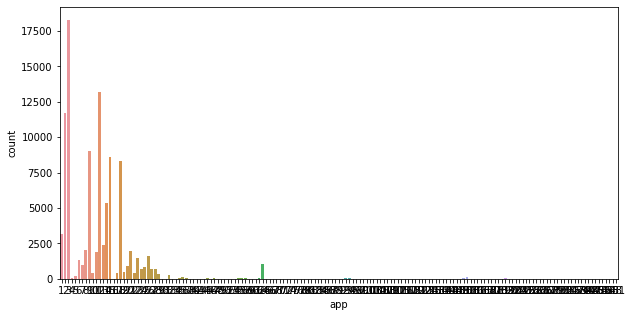

In [10]:
# count distribution of 'app' 
plt.figure(figsize = (10,5))
sns.countplot(x = 'app', data = train_sample)
plt.show()

some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)

Let us now plot device distribution below 

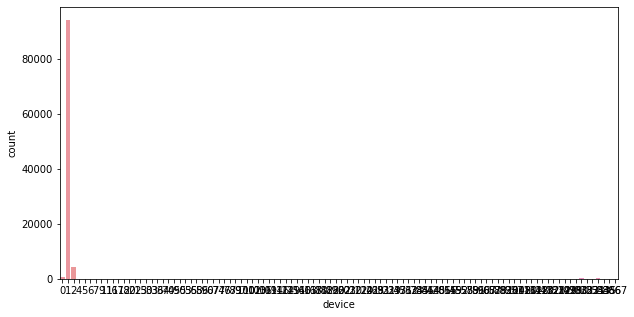

In [11]:
# distribution count of 'device' 
plt.figure(figsize = (10,5))
sns.countplot(x = 'device', data = train_sample)
plt.show()



The above result is expected because a few popular devices are used heavily

Let us now plot channel below

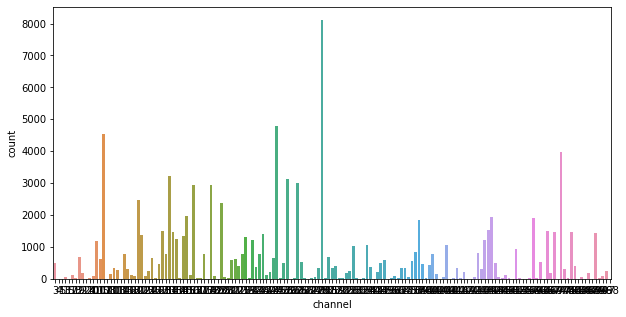

In [12]:
# distribution count of 'channel' 
plt.figure(figsize = (10,5))
sns.countplot(x = 'channel', data = train_sample)
plt.show()


you can see abobe that various channels get clicks in comparable quantities

Lets see distribution of 'os' now 

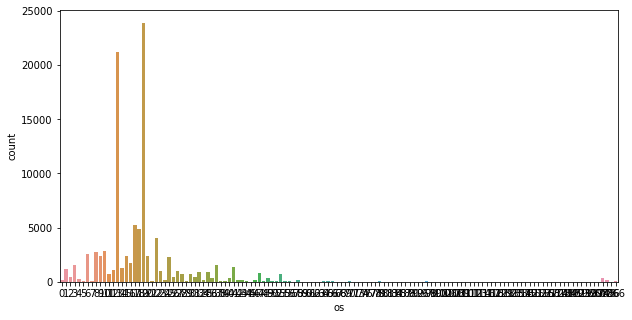

In [13]:
# distribution count of 'os' 
plt.figure(figsize = (10,5))
sns.countplot(x = 'os', data = train_sample)
plt.show()


there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 


Let's now look at the distribution of the target  variable 'is_attributed'.

In [14]:
# target variable distribution count
train_sample['is_attributed'].value_counts()/len(train_sample) * 100


0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% of clicks are 'fraudulent'**, which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [15]:
# Get average of 'is_attributed', or 'download rate' grouped with app
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])

# print app_target
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [16]:
# Make a 'count' column based on app size and reset index on count
frequent_apps = train_sample.groupby('app').size().reset_index(name = 'count')

# filter count greater than count above 80% quantile range
frequent_apps = frequent_apps[frequent_apps['count'] > frequent_apps['count'].quantile(0.80)]

#inner join frequent_apps with train_sample on 'app'
frequent_apps = frequent_apps.merge(train_sample, how = 'inner', on = 'app')


#print head of frequent_apps
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


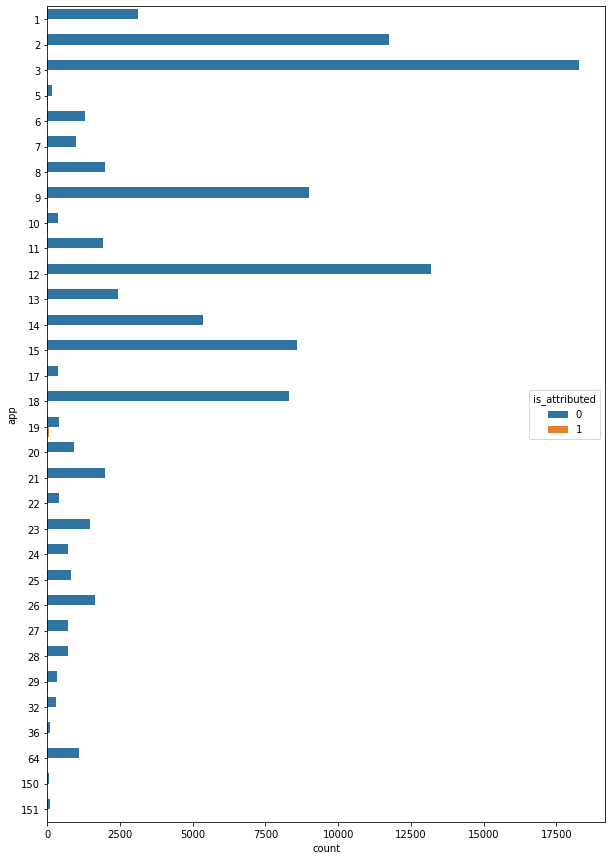

In [17]:
#plot count distribution of 'app' hued with 'is_attributed'
plt.figure(figsize = (10,15))
sns.countplot(y = 'app', data = frequent_apps, hue='is_attributed')
plt.show()



You can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

## Feature Engineering

<p style='text-align: right;'> 10 points</p>


Let's now derive some new features from the existing ones. There are a number of features one can extract from ```click_time``` itself, and by grouping combinations of IP with other features.

### Datetime Based Features


In [18]:
# Create a function which takes in a df, adds date/time based columns to it and returns the modified df

def timeFeatures(df):
    # Creating datetime variables using the click_time column 
    df['datetime'] = pd.to_datetime(df['click_time'])
    
    #Creating day_of_week variables extracting week from the datetime column 

    df['day_of_week'] = df['datetime'].dt.dayofweek
    
     #Creating day_of_year variables extracting day from the datetime column 

    df["day_of_year"] = df['datetime'].dt.dayofyear
    
    #Creating month variables extracting month from the datetime column 

    df["month"] = df['datetime'].dt.month
    
    #Creating hour variables extracting hour from the datetime column 

    df["hour"] = df['datetime'].dt.hour
    
    #return df
    return df

In [19]:
# creating new variables using above function with df as train_sample 
train_sample = timeFeatures(train_sample)

# dropping the click_time and datetime variables from train_sample
train_sample.drop(['click_time', 'datetime'], axis = 1, inplace = True)

#print train_sample head
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [20]:
# datatypes  of all variables in train_sample
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

note that by default the new datetime variables are int64


In [21]:
# check memory/space used by training data
print("Training data uses : ", train_sample.memory_usage().sum()/1024**2)

Training data uses :  4.100921630859375


Lets convert the variables back to lower dtype again


In [22]:
# get all int variables in a list
int_vars = ['day_of_week', 'day_of_year', 'month', 'hour']

# convert all above variables into uint16 type
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [23]:
#print datatype of all variables in train_sample
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [24]:
# space used by training data
print("Training data uses : ", train_sample.memory_usage().sum()/1024**2)

Training data uses :  1.812103271484375


Hope you undertood why we converted variables into uint16 datatype

Yes, you are right:) The primitive data types prefixed with "u" are unsigned versions with the same bit sizes. Effectively, this means they cannot store negative numbers, but on the other hand they can store positive numbers twice as large as their signed counterparts. 

This is why it saves memory usage.

### IP Grouping Based Features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

`number of clicks by count of IP address
Note that we are explicitly asking pandas to re-encode the aggregated features as 'int16' to save memory`

In [25]:
# Create a column 'ip_count' using number of clicks by count of IP address 
ip_count = train_sample.groupby('ip').size().reset_index(name = 'ip_count').astype('int16')

#print head of ip_count 
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc. 

The following function takes in a dataframe and creates these features.

In [26]:
'''creates groupings of IP addresses with other features and appends the new features to the df'''

def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name = 'ip_count').astype('uint16')
    # ip_day_hour
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name = 'ip_day_hour').astype('uint16')
#   ip_hour_channel
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name = 'ip_hour_channel').astype('uint16')
#   ip_hour_os
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name = 'ip_hour_os').astype('uint16')
#   ip_hour_app
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name = 'ip_hour_app').astype('uint16')
#   ip_hour_device
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name = 'ip_hour_device').astype('uint16')
    
    '''merge the new aggregated features with the df'''
    
#   left join ip_count to df on ip
    df = pd.merge(df, ip_count, on = 'ip', how = 'left')
    
#   delete ip_count
    del ip_count
    #left join ip_day_hour to df on ip, day_of_week and hour
    df = pd.merge(df, ip_day_hour, on = ['ip', 'day_of_week', 'hour'], how = 'left')
    
    #delete ip_day_hour
    del ip_day_hour
    
#   left join ip_hour_channel to df on ip, hour, channel
    df = pd.merge(df, ip_hour_channel, on = ['ip', 'hour', 'channel'], how = 'left')

    #   delete ip_hour_channel
    del ip_hour_channel
    #left join ip_hour_os to df on ip, hour and os
    df = pd.merge(df, ip_hour_os, on = ['ip', 'hour', 'os'], how = 'left')

    #   delete ip_hour_os
    del ip_hour_os
    
    #    left join ip_hour_app to df on ip, hour and app
    df = pd.merge(df, ip_hour_app, on = ['ip', 'hour', 'app'], how = 'left')
    
#     delete ip_hour_app 
    del ip_hour_app
    #left join ip_hour_device to df on ip , hour and device
    df = pd.merge(df, ip_hour_device, on = ['ip', 'hour', 'device'], how = 'left')

    #   delete ip_hour_device 
    del ip_hour_device
#  return df
    return df

In [27]:
#Use above grouped_features() function with train_sample as parameter to create your new train_sample data 
train_sample = grouped_features(train_sample)

In [28]:
#print head of train_sample
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [29]:
#check space usage of train_sample again
print("Training data uses : ", train_sample.memory_usage().sum()/1024**2)

Training data uses :  3.719329833984375


In [30]:
# garbage collect (unused) object using gc.collect()
gc.collect()

26729

## Modelling

<p style='text-align: right;'> 75 points</p>


Let's now build models to predict the variable ```is_attributed``` (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost, LightGBM and Catboost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the original Kaggle competition, the metric for model evaluation is **area under the ROC curve**.


In [31]:
# create X and y train
X = train_sample.drop('is_attributed', axis = 1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets with test_size as 20% and random state as 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101)

#print shape of X_train, y_train, X_test and y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [32]:
# check the average download rates in train 
print(y_train.mean())
# check the average download rates in test data, and check they should be comparable
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


### 1.  AdaBoost

Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Reference video: https://www.youtube.com/watch?v=NLRO1-jp5F8

AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique that is used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights to incorrectly classified instances. Boosting is used to reduce bias as well as the variance for supervised learning. It works on the principle where learners are grown sequentially. Except for the first, each subsequent learner is grown from previously grown learners. In simple words, weak learners are converted into strong ones. Adaboost algorithm also works on the same principle as boosting, but there is a slight difference in working. 

In [33]:
# Instantiate DecisionTreeClassifier with max_depth as 2 and random state as 1
tree = DecisionTreeClassifier(max_depth = 2, random_state = 1)

'''adaboost with the tree as base estimator, max 600 decision trees of depth=2, 
learning_rate/shrinkage=1.5 and algorithm as "SAMME" and random_state as 1'''

adaboost_model_1 = AdaBoostClassifier(base_estimator=tree, n_estimators=600, learning_rate=1.5, algorithm='SAMME', random_state=1)

In [34]:
# fit adaboost_model_1 with training dataset
adaboost_model_1.fit(X_train, y_train)



AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [35]:
# prediction probability on X_test
predictions = adaboost_model_1.predict_proba(X_test)

#print top 10 prediction result
predictions[:10]

array([[0.54049582, 0.45950418],
       [0.53588662, 0.46411338],
       [0.53885559, 0.46114441],
       [0.52427816, 0.47572184],
       [0.52018053, 0.47981947],
       [0.5308397 , 0.4691603 ],
       [0.53055748, 0.46944252],
       [0.54126954, 0.45873046],
       [0.52347347, 0.47652653],
       [0.51624249, 0.48375751]])

In above result the second column represents the probability of a click resulting in a download


In [36]:
# metrics: Get AUC score with parameters y_test and predicted probability result
metrics.roc_auc_score(y_test, predictions[:, 1])

0.9523839750549848

### AdaBoost - Hyperparameter Tuning

Let's now tune the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [37]:
# parameter grid with base_estimator__max_depth as [2,5] and n_estimators as [200, 400, 600]
param_grid = {'base_estimator__max_depth' : [2, 5], 'n_estimators' : [200, 400, 600]}

In [38]:
# DecisionTreeClassifier as base estimator with random_state=1
tree = DecisionTreeClassifier(random_state=1)

'''adaboost with the tree as base estimator and learning rate is arbitrarily set to 0.6, 
we'll discuss learning_rate below and algorithm as "SAMME"'''

ABC = AdaBoostClassifier(base_estimator=tree, learning_rate=0.6, algorithm = 'SAMME')

#### Run grid search CV


In [39]:
# Keep cross validation fold as 3
folds = 3

# run grid search with ABC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1
grid_search_ABC = GridSearchCV(ABC, cv = folds, param_grid=param_grid, scoring = 'roc_auc', return_train_score=True, verbose = 1)


In [40]:
# fit grid_search_ABC on training data
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

You must be thinking what is "SAMME" here, refer this doc: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html

In [41]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,11.170230,0.151285,0.326638,0.003205,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,22.423728,0.239115,0.636485,0.008977,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,33.526391,0.223587,0.923554,0.002838,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,0.000253
3,23.969401,0.291896,0.395526,0.002477,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902361,0.937557,0.937665,0.925861,0.016617,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,48.471054,0.274808,0.784904,0.023871,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890520,0.939826,0.945001,0.925115,0.024554,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,72.547488,0.403363,1.132161,0.004004,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.886184,0.941086,0.934272,0.920514,0.024434,6,1.000000,1.000000,1.000000,1.000000,0.000000


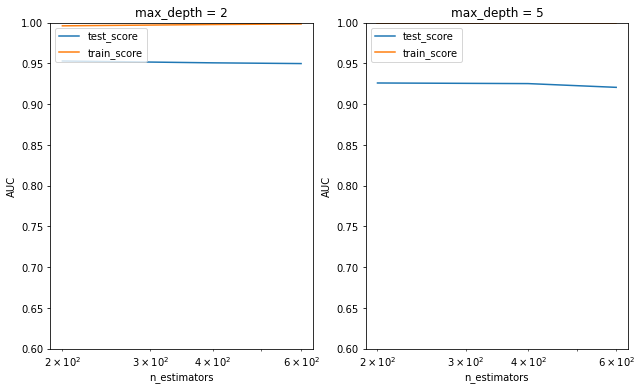

In [42]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3,n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth'] == depth]
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_test_score'])
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_train_score'])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title('max_depth = {0}'.format(depth))
    plt.ylim([0.60,1])
    plt.legend(['test_score', 'train_score'], loc = 'upper left')
    plt.xscale('log')

The results above show that:
- The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
- At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score 

Thus, we should go ahead with ```max_depth=2``` and ```n_estimators=200```.

Note that we haven't experimented with many other important hyperparameters till now, such as ```learning rate```, ```subsample``` etc., and the results might be considerably improved by tuning them. We'll next experiment with these hyperparameters.

As of now again rebuild AdaBoostClassifier with chosen hyperparameters

In [43]:
# DecisionTreeClassifier  as base estimator with max_depth as 2 and random_state as 1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

'''adaboost with the tree as base estimator learning rate is arbitrarily set as 0.6, 
    n_eastimator as 200, random_state as 1, algorithm as "SAMME" '''

ABC = AdaBoostClassifier(base_estimator=tree, learning_rate=0.6, n_estimators=200, algorithm="SAMME", random_state=1)
# fitting ABCon training data
ABC.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [44]:
# predict on test data
predictions = ABC.predict_proba(X_test) 

# print top 10 prediction probabilities
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [45]:
# Calculate roc auc score 
metrics.roc_auc_score(y_test, predictions[:,1])

0.960727748545338

Well done, you have improved the model and adaboost gave us 96% of roc_auc coverage, which is a kind of good coverage

### 2. Gradient Boosting Classifier



Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Reference video: https://www.youtube.com/watch?v=j034-r3O2Cg

Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. 

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

In [46]:
# parameter grid with learning_rate as [0.2, 0.6, 0.9] and subsample as [0.3, 0.6, 0.9]
param_grid = {'learning_rate' : [0.2, 0.6, 0.9], 'subsample' : [0.3, 0.6, 0.9]}

In [47]:
# Gradient boost as base estimator with max_depth as 2 and n_estimators as 200 and random_state as 1
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200, random_state=1)

##### Run grid search


In [48]:
# CV folds as 3
folds = 3

#Instantiate grid search with GBC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1

grid_search_GBC = GridSearchCV(GBC, cv = folds, param_grid = param_grid, scoring='roc_auc', return_train_score=True, verbose = 1)

# grid_search_GBC fit on training data 
grid_search_GBC.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
         

In [49]:
# cv results

cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.665972,0.024232,0.040279,0.000993,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.777582,0.667045,0.884576,0.776401,0.088811,3,0.848509,0.771451,0.843124,0.821028,0.035125
1,8.346805,0.052872,0.040761,0.001250,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.880967,0.878956,0.751848,0.837257,0.060399,2,0.905836,0.949851,0.741464,0.865717,0.089679
2,10.579158,0.016881,0.043071,0.003982,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.799695,0.823715,0.899856,0.841089,0.042696,1,0.858151,0.815856,0.904002,0.859336,0.035995
3,5.681023,0.049175,0.040355,0.000878,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.712614,0.171713,0.632072,0.505466,0.238279,7,0.617595,0.177567,0.654294,0.483152,0.216600
4,8.367862,0.046687,0.041597,0.000358,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.489959,0.654872,0.603384,0.582738,0.068890,6,0.452552,0.684572,0.634142,0.590422,0.099639


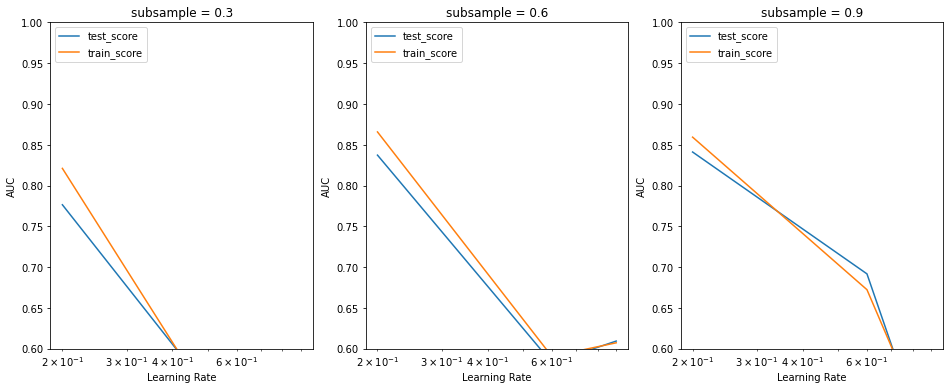

In [50]:
# # plotting AUC with hyperparameter combinations i.e subsample

plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1, len(param_grid['subsample']), n+1)
    dataframe = cv_results[cv_results['param_subsample'] == subsample]
    plt.plot(dataframe['param_learning_rate'], dataframe['mean_test_score'])
    plt.plot(dataframe['param_learning_rate'], dataframe['mean_train_score'])
    plt.xlabel('Learning Rate')
    plt.ylabel('AUC')
    plt.title("subsample = {0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test_score', 'train_score'], loc = 'upper left')
    plt.xscale('log')



It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit. 

Also, a lower learning rate results in less overfitting.

In [51]:
# fitting GBC training data
GBC.fit(X_train, y_train)


# predict probabilities on test data
predictions = GBC.predict_proba(X_test)

# print top 10 prediction probabilities
predictions[:10]

array([[9.99759635e-01, 2.40365249e-04],
       [9.99683461e-01, 3.16539468e-04],
       [9.99385527e-01, 6.14472923e-04],
       [9.99790280e-01, 2.09720179e-04],
       [9.99189954e-01, 8.10045513e-04],
       [9.99824758e-01, 1.75242409e-04],
       [9.99618179e-01, 3.81820940e-04],
       [9.99712348e-01, 2.87651814e-04],
       [9.99781825e-01, 2.18175325e-04],
       [9.98997601e-01, 1.00239939e-03]])

In [52]:
# Calculate roc auc score 
metrics.roc_auc_score(y_test, predictions[:, 1])

0.9599148083187171

So Gradient boosting also gives us 96% of roc_auc coverage

### 3. XGBoost

Reference video: https://www.youtube.com/watch?v=gPciUPwWJQQ

Reference doc:https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.


In [53]:
# Instantiate XGBClassifier with default hyperparameters and random_state=1
model = XGBClassifier(random_state=1)
 
# fit model on training data
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Make predictions for test data


In [54]:
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)

#print top 10 y_pred result
y_pred[:10]

array([[9.9987620e-01, 1.2377757e-04],
       [9.9980235e-01, 1.9764129e-04],
       [9.9981219e-01, 1.8779545e-04],
       [9.9935341e-01, 6.4659910e-04],
       [9.9839455e-01, 1.6054598e-03],
       [9.9982888e-01, 1.7113073e-04],
       [9.9954700e-01, 4.5297624e-04],
       [9.9944913e-01, 5.5086729e-04],
       [9.9976951e-01, 2.3048650e-04],
       [9.9696469e-01, 3.0353032e-03]], dtype=float32)

In [55]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 94.85%


The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here: http://xgboost.readthedocs.io/en/latest/parameter.html


Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

##### hyperparameter tuning with XGBoost


In [56]:

# creating a KFold object( 3 )
folds = 3

# specify range of hyperparameters with learning_rate as [0.2, 0.6] ans subsample as [0.3, 0.6, 0.9]
param_grid = {'learning_rate' : [0.2, 0.6], 'subsample' : [0.3, 0.6, 0.9]}      


# specify model with max_depth as 2 and n_estimators as 200 and random_state as 1
xgb_model = XGBClassifier(max_depth = 2, n_estimators=200, random_state=1)

# set up GridSearchCV() with xgb_model, param_grid, folds, return_train_score and verbose as 1 and scoring as roc_auc
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [57]:
# fit the model_cv on training data
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [58]:
# Get cv results as datafame
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.226849,0.038031,0.138335,0.003595,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.918476,0.966470,0.959373,0.948106,0.021151,3,0.990313,0.984284,0.993700,0.989432,0.003894
1,5.844941,0.004914,0.129748,0.001285,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.933275,0.978913,0.950468,0.954218,0.018819,1,0.993116,0.987288,0.994242,0.991549,0.003047
2,4.928996,0.022239,0.130195,0.003901,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924940,0.973210,0.950138,0.949429,0.019712,2,0.993739,0.989940,0.994238,0.992639,0.001919
3,5.237801,0.021123,0.134964,0.001213,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.903041,0.948284,0.920718,0.924014,0.018617,6,0.997775,0.995323,0.996475,0.996525,0.001002
4,5.893528,0.020184,0.135432,0.001508,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.909776,0.970954,0.944572,0.941768,0.025054,4,0.999613,0.998645,0.999649,0.999303,0.000465
5,4.980464,0.016001,0.132820,0.004244,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.900652,0.967076,0.950202,0.939310,0.028190,5,0.999575,0.999293,0.999550,0.999473,0.000127


Convert parameters to int for plotting on x-axis


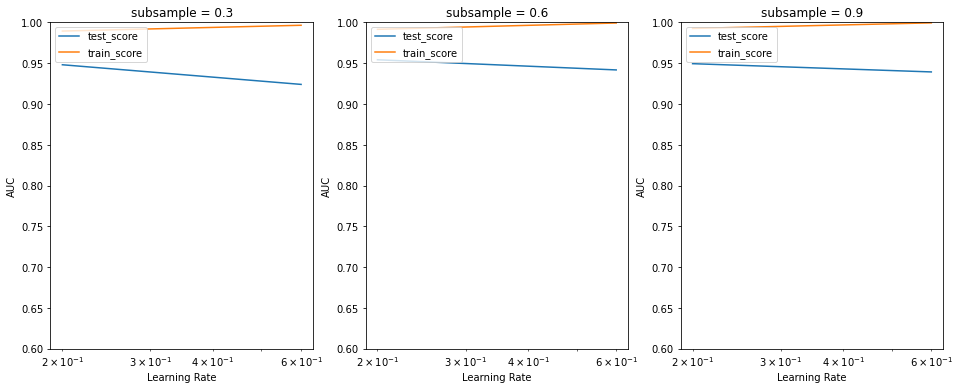

In [59]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1, len(param_grid['subsample']), n+1)
    dataframe = cv_results[cv_results['param_subsample'] == subsample]
    plt.plot(dataframe['param_learning_rate'], dataframe['mean_test_score'])
    plt.plot(dataframe['param_learning_rate'], dataframe['mean_train_score'])
    plt.xlabel('Learning Rate')
    plt.ylabel('AUC')
    plt.title("subsample = {0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test_score', 'train_score'], loc = 'upper left')
    plt.xscale('log')
    
    

The results show that a subsample size of 0.6 and learning_rate of about 0.2 seems optimal. 

Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 


Let's build a final model with the chosen hyperparameters ie.


`'learning_rate': 0.2,
'max_depth': 2, 
'n_estimators':200,
'subsample':0.6,
'random_state':1`


In [60]:
# 4 chosen hyperparameters and use 'objective':'binary:logistic' which outputs probability rather than label, which we need for auc
params = {'learning_rate' : 0.2, 'max_depth' : 2, 'n_estimators' : 200, 'subsample' : 0.6, 'random_state' : 1, 'objective' : 'binary:logistic'}


#Instantiate XGBClassifier with params
XGB = XGBClassifier(params = params)

# fit model on training data
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'random_state': 1,
                      'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [63]:
# get prediction probability
y_pred = XGB.predict_proba(X_test)

#print to 10 prediction result
y_pred[:10]

array([[9.9987620e-01, 1.2377757e-04],
       [9.9980235e-01, 1.9764129e-04],
       [9.9981219e-01, 1.8779545e-04],
       [9.9935341e-01, 6.4659910e-04],
       [9.9839455e-01, 1.6054598e-03],
       [9.9982888e-01, 1.7113073e-04],
       [9.9954700e-01, 4.5297624e-04],
       [9.9944913e-01, 5.5086729e-04],
       [9.9976951e-01, 2.3048650e-04],
       [9.9696469e-01, 3.0353032e-03]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [64]:
# print roc_auc score
auc = metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.9484868732425735

Even after hyerparameter tuning we got same roc_auc score. Finally, let's also look at the feature importances.

In [65]:
# print feature importance for each column in  a dictionary form
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'app': 0.27878824,
 'channel': 0.21394157,
 'day_of_week': 0.02267693,
 'day_of_year': 0.0,
 'device': 0.17192616,
 'hour': 0.03604142,
 'ip': 0.04729222,
 'ip_count': 0.121292084,
 'ip_day_hour': 0.0,
 'ip_hour_app': 0.0,
 'ip_hour_channel': 0.0,
 'ip_hour_device': 0.0,
 'ip_hour_os': 0.008167093,
 'month': 0.0,
 'os': 0.09987429}

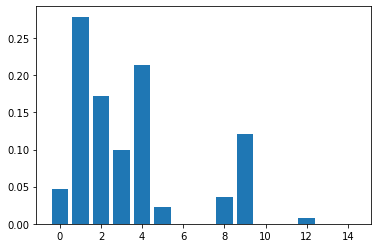

In [66]:
# plot feature importance for every column
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

## 4.  LightGBM

Reference doc: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Reference video: https://www.youtube.com/watch?v=Ph2nbuhOT04

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

**Advantages of Light GBM**

1. Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
2. Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
3. Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
4. Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
5. Parallel learning supported.

I guess you must have got excited about the advantages of Light GBM. So lets get started with it

In [67]:
# import lightgbm as LGBMClassifier
from lightgbm import LGBMClassifier
# Instantiate LGBMClassifier with default hyperparameters and random_state=1
LGB = LGBMClassifier(random_state = 1)
 
# fit model on training data
LGB.fit(X_train, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
# use predict_proba since we need probabilities to compute auc
y_pred = LGB.predict_proba(X_test)

#print top 10 y_pred result
y_pred[:10]

array([[1.00000000e+000, 0.00000000e+000],
       [9.99998990e-001, 1.01030903e-006],
       [1.00000000e+000, 2.82994650e-030],
       [1.00000000e+000, 7.33590054e-049],
       [9.99994630e-001, 5.36963442e-006],
       [1.15824239e-009, 9.99999999e-001],
       [1.00000000e+000, 6.24697059e-143],
       [1.00000000e+000, 7.99709263e-127],
       [1.00000000e+000, 0.00000000e+000],
       [9.99938530e-001, 6.14704228e-005]])

In [69]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 80.28%


Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the LightGBM with previous selected hyperparamters i.e.

`'learning_rate': 0.2,
'max_depth': 2, 
'n_estimators':200,
'subsample':0.6,
'random_state':1`
         
Lets see if it improves

In [70]:
# Instantiate XGBClassifier with above parameters
LGB = LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6, random_state = 1)
 
# fit model on training data
LGB.fit(X_train, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [71]:
# use predict_proba since we need probabilities to compute auc
y_pred = LGB.predict_proba(X_test)

# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 73.16%


Oh man! even after tuning we have got lower AUC score. That's fine let us try our final model which is CatBoost.


## 5. CatBoost

Reference doc: https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html4

Reference video: https://www.youtube.com/watch?v=mUGAA02fGuw


CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML. It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

It is especially powerful in two ways:

It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.
“CatBoost” name comes from two words “Category” and “Boosting”.

As discussed, the library works well with multiple Categories of data, such as audio, text, image including historical data.


In [74]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [75]:
# import CatBoostClassifier
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with default hyperparameters and random_state=1
Cat = CatBoostClassifier(random_state = 1)
 
# fit model on training data
Cat.fit(X_train, y_train)



Learning rate set to 0.06692
0:	learn: 0.5108028	total: 79.5ms	remaining: 1m 19s
1:	learn: 0.3708254	total: 108ms	remaining: 53.9s
2:	learn: 0.2729352	total: 138ms	remaining: 45.8s
3:	learn: 0.2003892	total: 167ms	remaining: 41.5s
4:	learn: 0.1526434	total: 201ms	remaining: 40s
5:	learn: 0.1183977	total: 231ms	remaining: 38.2s
6:	learn: 0.0927923	total: 261ms	remaining: 37.1s
7:	learn: 0.0742122	total: 300ms	remaining: 37.1s
8:	learn: 0.0609728	total: 329ms	remaining: 36.2s
9:	learn: 0.0466541	total: 358ms	remaining: 35.5s
10:	learn: 0.0388333	total: 389ms	remaining: 35s
11:	learn: 0.0330372	total: 421ms	remaining: 34.6s
12:	learn: 0.0289984	total: 450ms	remaining: 34.2s
13:	learn: 0.0251513	total: 484ms	remaining: 34.1s
14:	learn: 0.0218230	total: 516ms	remaining: 33.9s
15:	learn: 0.0197052	total: 548ms	remaining: 33.7s
16:	learn: 0.0177425	total: 578ms	remaining: 33.4s
17:	learn: 0.0161975	total: 608ms	remaining: 33.2s
18:	learn: 0.0151140	total: 641ms	remaining: 33.1s
19:	learn: 0.0

Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the CatBoost with previous selected hyperparamters i.e

`learning_rate=0.2,
max_depth=2,
n_estimators=200,
subsample=0.6,
random_state=1`

and lets see if it improves

In [76]:

# Instantiate CatBoostClassifier mentioned parameters
Cat = CatBoostClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6, random_state=1)
 
# fit model on training data
Cat.fit(X_train, y_train)


0:	learn: 0.2613983	total: 23.9ms	remaining: 4.76s
1:	learn: 0.1108282	total: 51.5ms	remaining: 5.1s
2:	learn: 0.0568219	total: 95.4ms	remaining: 6.27s
3:	learn: 0.0348754	total: 117ms	remaining: 5.72s
4:	learn: 0.0248676	total: 137ms	remaining: 5.34s
5:	learn: 0.0195423	total: 157ms	remaining: 5.07s
6:	learn: 0.0164517	total: 177ms	remaining: 4.88s
7:	learn: 0.0144602	total: 198ms	remaining: 4.76s
8:	learn: 0.0137709	total: 218ms	remaining: 4.63s
9:	learn: 0.0131070	total: 241ms	remaining: 4.58s
10:	learn: 0.0127104	total: 262ms	remaining: 4.5s
11:	learn: 0.0125925	total: 285ms	remaining: 4.47s
12:	learn: 0.0123707	total: 311ms	remaining: 4.47s
13:	learn: 0.0122557	total: 334ms	remaining: 4.43s
14:	learn: 0.0119429	total: 353ms	remaining: 4.35s
15:	learn: 0.0118920	total: 376ms	remaining: 4.32s
16:	learn: 0.0116891	total: 398ms	remaining: 4.28s
17:	learn: 0.0115157	total: 420ms	remaining: 4.24s
18:	learn: 0.0114131	total: 440ms	remaining: 4.2s
19:	learn: 0.0112984	total: 465ms	remaini

In [77]:
# use predict_proba since we need probabilities to compute auc
y_pred = Cat.predict_proba(X_test)

# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.29%


Wohoo! oh yes. Your final model can come to your rescue. CatBoost gives slightly better result than all other models which we tried till now.


Recommendations for training:
- We have used only a fraction of the training set (train_sample, 100k rows), the full training data on Kaggle (train.csv) has about 180 million rows. You'll get good results only if you train the model on a significant portion of the training dataset.  
- Because of the size, you'll need to use Colab kernels to train the model on full training data. Colab kernels provide powerful computation capacities on cloud (for free). 
- Even on the kernel, you may need to use a portion of the training dataset (try using the last 20-30 million rows).
- Make sure you save memory by following some tricks and best practices, else you won't be able to train the model at all on a large dataset.


Finally in this assignment you have learned about various boosting techniques and in previous assignment you had learned about Bagging techniques. We hope you understood the difference between them and their use.

To get a short ensemble summary refer: https://www.youtube.com/watch?v=m-S9Hojj1as

You can refer below videos to know interesting Interview questions on Boosting techniques. 

https://www.youtube.com/watch?v=EHewTwtYcgE




From above you can see that most of the International footbal tournament were on sunday. Such small small analysis becomes usefull for our machine learning problems to solve.

All these feature engineering techniques becomes very important to bring good insights and results for any machine learning problems, hence we hope that you understand the importance of feature engineering as part of data science.

---------------------
# Peaceable with ensemble! Congrats..you have completed your ML Ensemble challenge
---------------------


# FeedBack
We hope you’ve enjoyed this course so far. We’re committed to help you use "AI for All" course to its full potential, so that you have a great learning experience. And that’s why we need your help in form of a feedback here.

Please fill this feedback form https://zfrmz.in/MtRG5oWXBdesm6rmSM7N